In [54]:
import numpy as np
import math
from fractions import Fraction
import itertools
from biotuner_utils import *
from biotuner_offline import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn
from biotuner import *
import mne
import os
import time

## Load dataset

In [10]:

#path = 'D:/Science/EEG_data/'
path = 'C:/Users/Dell/GitHub/CoCoBrainChannel/'
epochs = mne.read_epochs(path+'pareidolia_run2.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(0.5, 7.5)
epochs_data = epochs.get_data()

Reading C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif ...


<ipython-input-10-4c36a6ad8073>:3: RuntimeWarning: This filename (C:/Users/Dell/GitHub/CoCoBrainChannel/pareidolia_run2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(path+'pareidolia_run2.fif')


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available


C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
C:\Users\Dell\Anaconda3\lib\site-packages\mne\io\tag.py

104 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


## Initialize biotuner object and methods

In [184]:
class biotuner(object):
    
    '''Class used to derive peaks information, musical scales and related metrics from time series  
    
    Example of use:       
    biotuning = biotuner(sf = 1000)
    biotuning.peaks_extraction(data)
    biotuning.peaks_extension()
    biotuning.peaks_metrics()
    '''
    
    def __init__(self, sf, peaks_function = 'EEMD', precision = 0.1, compute_sub_ratios = False, 
                 n_harm = 10, harm_function = 'mult', extension_method = 'consonant_harmonic_fit',
                 ratios_n_harms = 5, ratios_harms = False, ratios_inc = False, ratios_inc_fit = False):
        '''
        sf: int
            sampling frequency (in Hz)
            
        ///// PEAKS EXTRACTION ARGUMENTS ///// 
        peaks_function: str
            Defaults to 'EEMD'.
            Defines the method to use for peak extraction
            Peaks values are defined as the frequency value of the FFT bin with maximum amplitude 
            'fixed' : ranges of frequency bands are fixed
            'adapt' : ranges of frequency bands are defined based on the alpha peak
            'EMD': Intrinsic Mode Functions (IMFs) are derived from Empirical Mode Decomposition (EMD)  
                   FFT is computed on each IMF
            'EEMD': Intrinsic Mode Functions (IMFs) are derived from Ensemble Empirical Mode Decomposition (EMD)  
                    FFT is computed on each IMF
            'HH1D_max': maximum values of the 1d Hilbert-Huang transform on each IMF using EEMD.
            'harmonic_peaks': keeps peaks for which a maximum of other peaks are harmonics
        precision: float
            Defaults to 0.1
            precision of the peaks (in Hz)
            When HH1D_max is used, bins are in log scale.
        compute_sub_ratios: str
            Default to False
            When set to True, include ratios < 1 in peaks_ratios attribute
            
        ///// EXTENDED PEAKS ARGUMENTS /////
        n_harm: int
            Defaults to 10.
            Set the number of harmonics to compute in harmonic_fit function
        harm_function: str
            Defaults to 'mult'
            Computes harmonics from iterative multiplication (x, 2x, 3x, ...nx) or division (x, x/2, x/3, ...x/n)
            Set to 'mult' or 'div'  
        extension_method: str
            ['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']
            
        ///// RATIOS EXTENSION ARGUMENTS /////
        ratios_n_harms: int
            Defaults to 5.
            Defines to number of harmonics or exponents for extended ratios
        ratios_harms: boolean
            Defaults to False.
            When set to True, harmonics (x*1, x*2, x*3...,x*n) of specified ratios will be computed.
        ratios_inc: boolean
            Defaults to False.
            When set to True, exponentials (x**1, x**2, x**3,...x**n) of specified ratios will be computed.
        ratios_inc_fit: boolean
            Defaults to False.
            When set to True, a fit between exponentials (x**1, x**2, x**3,...x**n) of specified ratios will be computed.
        
        '''
        self.sf = sf
        '''Initializing arguments for peak extraction'''
        self.peaks_function = peaks_function
        self.precision = precision
        self.compute_sub_ratios = compute_sub_ratios
        '''Initializing arguments for peaks metrics'''
        self.n_harm = n_harm
        self.harm_function = harm_function
        self.extension_method = extension_method
        '''Initializing dictionary for scales metrics'''
        self.scale_metrics = {}
        '''Initializing arguments for ratios extension'''
        self.ratios_n_harms = ratios_n_harms
        self.ratios_harms = ratios_harms
        self.ratios_inc = ratios_inc
        self.ratios_inc_fit = ratios_inc_fit
        
    
    
    '''First method to use. Requires data as input argument
       Generates self.peaks and self.peaks_ratios attributes'''

    def peaks_extraction (self, data, peaks_function = None, FREQ_BANDS = None, precision = None, sf = None, min_freq = 1, max_freq = 80, min_harms = 2, 
                          compute_sub_ratios = None, ratios_extension = False):
        '''
        
        Arguments
        -------------
        
        data: 1d array (float)
            biosignal to analyse
            
        peaks_function: refer to __init__
        
        FREQ_BANDS: 
        Attributes
        -------------
        self.peaks: List (float)
            List of frequency peaks
            
        '''
        
        self.data = data
        if sf == None:
            sf = self.sf
        if precision == None:
            precision = self.precision
        if peaks_function == None:
            peaks_function = self.peaks_function
        if compute_sub_ratios == None:
            compute_sub_ratios = self.compute_sub_ratios
        self.peaks, self.amps = self.compute_peaks_ts (data, peaks_function = peaks_function, FREQ_BANDS = FREQ_BANDS, precision = precision, 
                                                       sf = sf, min_freq = min_freq, max_freq = max_freq, min_harms = 2)

        self.peaks_ratios = compute_peak_ratios(self.peaks, rebound = True, octave = 2, sub = compute_sub_ratios)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.peaks_ratios)
            if a != None:
                self.peaks_ratios_harms = a
            if b != None:
                self.peaks_ratios_inc = b
            if c != None:
                self.peaks_ratios_inc_fit = c
    '''Generates self.extended_peaks and self.extended_peaks_ratios attributes'''
    
    def peaks_extension (self, peaks = None, n_harm = None, method = None, harm_function = 'mult', div_mode = 'add',
                         cons_limit = 0.1, ratios_extension = False):
        if peaks == None:
            peaks = self.peaks
        if n_harm == None:
            n_harm = self.n_harm
        if method == None:
            method = self.extension_method
        if method == 'harmonic_fit':
            extended_peaks = harmonic_fit(peaks, n_harm, function = harm_function, div_mode = div_mode)
            self.extended_peaks = np.sort(list(self.peaks)+list(extended_peaks))
        if method == 'consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant':
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        if method == 'consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, n_harm, function = harm_function, div_mode = div_mode)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(cons_peaks, 3))
        if method == 'multi_consonant_harmonic_fit':
            extended_peaks = harmonic_fit(peaks, n_harm, function = harm_function, div_mode = div_mode)
            consonance, cons_pairs, cons_peaks, cons_metric = consonance_peaks (extended_peaks, limit = cons_limit)
            self.extended_peaks = np.sort(np.round(multi_consonance(cons_pairs, n_freqs = 10), 3))
        self.extended_peaks = [i for i in self.extended_peaks if i<self.sf/2]
        self.extended_amps = peaks_to_amps(self.extended_peaks, self.freqs, self.psd, self.sf)
        self.extended_peaks_ratios = compute_peak_ratios(self.extended_peaks, rebound = True)
        if ratios_extension == True:
            a, b, c = self.ratios_extension(self.extended_peaks_ratios)
            if a != None:
                self.extended_peaks_ratios_harms = a
            if b != None:
                self.extended_peaks_ratios_inc = b
            if c != None:
                self.extended_peaks_ratios_inc_fit = c
    
    def ratios_extension (self, ratios, ratio_fit_bounds = 0.001):
        if self.ratios_harms == True:
            ratios_harms_ = ratios_harmonics(ratios, self.ratios_n_harms)
        else: 
            ratios_harms_ = None
        if self.ratios_inc == True:
            ratios_inc_ = ratios_increments(ratios, self.ratios_n_harms)
        else: 
            ratios_inc_ = None
        if self.ratios_inc_fit == True:
            ratios_inc_fit_ = harmonic_fit(ratios, self.ratios_n_harms, function = 'exp', bounds = ratio_fit_bounds)
        else: 
            ratios_inc_fit_ = None
        return ratios_harms_, ratios_inc_, ratios_inc_fit_
    
    def compute_spectromorph (self, IMFs = None, sf = None, method = 'SpectralCentroid', window = None, overlap = 1, comp_chords = False, min_notes = 3, 
                              cons_limit = 0.2, cons_chord_method = 'cons', graph = False):
        if IMFs == None:
            try:
                IMFs = self.IMFs
            except:
                IMFs = EMD_eeg(self.data)[1:6]
                self.IMFs = IMFs
                
        if sf == None:
            sf = self.sf
        if window == None:
            window = int(sf/2)
            
        spectro_EMD = EMD_to_spectromorph(IMFs, 1000, method = method, window = window, overlap = overlap)
        self.spectro_EMD = np.round(spectro_EMD, 1)
        if method == 'SpectralCentroid':
            self.SpectralCentroid = self.spectro_EMD
        if method == 'SpectralFlux':
            self.SpectralFlux = self.spectro_EMD
        if comp_chords == True:
            self.spectro_chords, spectro_chord_pos = timepoint_consonance(self.spectro_EMD, method = cons_chord_method, 
                                                                               limit = cons_limit, min_notes = min_notes)  
        if graph == True:
            data = np.moveaxis(self.spectro_EMD, 0, 1)
            ax = sbn.lineplot(data=data[10:-10, :], dashes = False)
            print('2')
            ax.set(xlabel='Time Windows', ylabel=method)
            ax.set_yscale('log')
            plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='EMDs', loc = 'best')
            labels = ['EMD1', 'EMD2', 'EMD3', 'EMD4', 'EMD5', 'EMD6']
            for xc in spectro_chord_pos:
                plt.axvline(x=xc, c='black', linestyle = 'dotted')
            plt.show()
            
    def compute_peaks_metrics (self, n_harm = None):
        if n_harm == None:
            n_harm = self.n_harm
            
        peaks = list(self.peaks)
        metrics = {'cons' : 0, 'euler' : 0, 'tenney': 0, 'harm_fit': 0, 'harmsim':0}   
        metrics['harm_fit'] = len(harmonic_fit(peaks, n_harm = n_harm))
        a, b, c, metrics['cons'] = consonance_peaks (peaks, 0.1)
        peaks_euler = [int(round(num, 2)*1000) for num in peaks]
        metrics['euler'] = euler(*peaks_euler)
        metrics['tenney'] = tenneyHeight(peaks)
        metrics['harmsim'] = np.average(ratios2harmsim(biotuning.peaks_ratios[:-1]))
        metrics_list = []
        for value in metrics.values():
            metrics_list.append(value)
        self.peaks_metrics_list = metrics_list
        self.peaks_metrics = metrics

    '''Methods to compute scales from whether peaks or extended peaks'''
    
    def compute_diss_curve (self, input_type = 'peaks', denom=1000, max_ratio=2, euler_comp = False, method = 'min', plot = False, n_tet_grid = 12):
        if input_type == 'peaks':
            peaks = self.peaks
            amps = self.amps
        if input_type == 'extended_peaks':
            peaks = self.extended_peaks
            amps = self.extended_amps

        peaks = [p*128 for p in peaks]
        amps = np.interp(amps, (np.array(amps).min(), np.array(amps).max()), (0.2, 0.8))
        
        intervals, self.diss_scale, euler_diss, diss, harm_sim_diss = diss_curve (peaks, amps, denom=denom,
                                                                                  max_ratio=max_ratio, euler_comp = euler_comp,
                                                                                  method = method, plot = plot, n_tet_grid = n_tet_grid)
        print('intervals', intervals)
        self.scale_metrics['diss_euler'] = euler_diss
        self.scale_metrics['dissonance'] = diss
        self.scale_metrics['diss_harm_sim'] = np.average(harm_sim_diss)
        self.scale_metrics['diss_n_steps'] = len(self.diss_scale)
        
    def compute_harmonic_entropy(self, input_type = 'peaks', res = 0.001, spread = 0.01, 
                                 plot_entropy = True, plot_tenney = False, octave = 2, rebound = True, sub = False):
        if input_type == 'peaks':
            ratios = compute_peak_ratios(self.peaks, rebound = rebound, sub = sub)
        if input_type == 'extended_peaks':
            ratios = compute_peak_ratios(self.extended_peaks, rebound = rebound, sub = sub)
        if input_type == 'extended_ratios_harms':
            ratios = self.extended_peaks_ratios_harms
        if input_type == 'extended_ratios_inc':
            ratios = self.extended_peaks_ratios_inc
        if input_type == 'extended_ratios_inc_fit':
            ratios = self.extended_peaks_ratios_inc_fit
            
        HE_scale, HE = harmonic_entropy(ratios, res = res, spread = spread, plot_entropy = plot_entropy, plot_tenney = plot_tenney, octave = octave)
        self.HE_scale = HE_scale[0]
        self.scale_metrics['HE'] = HE
        self.scale_metrics['HE_n_steps'] = len(self.HE_scale)  
        self.scale_metrics['HE_harm_sim'] = np.average(ratios2harmsim(list(biotuning.HE_scale)))
        '''
        ratios_euler = [a]+ratios
        ratios_euler = [int(round(num, 2)*1000) for num in ratios]
        euler_score = None
        if consonance == True:
            euler_score = euler(*ratios_euler)
            euler_score = euler_score/len(diss_minima)
        '''
    
    
    
    
    '''Methods called by the peaks_extraction method'''
    
    def compute_peak(self, eeg_data, sf=1000, nperseg = 0, nfft = 0, precision = 0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
        self.freqs = freqs
        self.psd = psd
        psd = 10. * np.log10(psd) 
        bin_size = (sf/2)/len(freqs)
        #min_index = int(minf/bin_size)
        #max_index = int(maxf/bin_size)
        index_max = np.argmax(np.array(psd))
        FREQS = np.array(freqs[index_max])
        amps = np.array(psd[index_max])

        return FREQS, amps
    
    def compute_peaks_raw(self, eeg_data, FREQ_BANDS, sf=1000, nperseg = 0, nfft = 0, precision=0.25, average = 'median'):
        if nperseg == 0:
            mult = 1/precision
            nperseg = sf*mult
            nfft = nperseg
        import scipy
        psd_all = []
        freqs_all = []
        FREQs_temp= []
        amp_temp = []

        for minf, maxf in FREQ_BANDS:
            freqs, psd = scipy.signal.welch(eeg_data, sf, nfft = nfft, nperseg = nperseg, average = average)
            self.freqs = freqs
            psd = 10. * np.log10(psd)
            self.psd = psd
            bin_size = (sf/2)/len(freqs)
            self.bin_size = bin_size
            min_index = int(minf/bin_size)
            max_index = int(maxf/bin_size)
            index_max = np.argmax(np.array(psd[min_index:max_index]))
             #   print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
            FREQs_temp.append(freqs[min_index+index_max])
            amp_temp.append(psd[min_index+index_max])

        FREQS = np.array(FREQs_temp)
        amps = np.array(amp_temp)
        return FREQS, amps
    
    def extract_all_peaks (self, data, sf, precision, max_freq = None):
        if max_freq == None:
            max_freq = sf/2
        mult = 1/precision
        nperseg = sf*mult
        nfft = nperseg
        freqs, psd = scipy.signal.welch(data, sf, nfft = nfft, nperseg = nperseg, average = 'median')
        psd = 10. * np.log10(psd)
        self.freqs = freqs
        self.psd = psd
        indexes = ss.find_peaks(psd, height=None, threshold=None, distance=10, prominence=None, width=2, wlen=None, rel_height=0.5, plateau_size=None)
        peaks = []
        amps = []
        for i in indexes[0]:
            peaks.append(freqs[i])
            amps.append(psd[i])
        peaks = np.around(np.array(peaks), 5)
        peaks = list(peaks)
        peaks = [p for p in peaks if p<=max_freq]
        return peaks, amps

    def compute_peaks_ts (self, data, peaks_function = 'EMD', FREQ_BANDS = None, precision = 0.25, sf = 1000, min_freq = 1, max_freq = 80, min_harms = 2):
        alphaband = [[7, 12]]
        try:
            if FREQ_BANDS == None:
                FREQ_BANDS = [[2, 3.55], [3.55, 7.15], [7.15, 14.3], [14.3, 28.55], [28.55, 49.4]]
        except:
            pass
        if peaks_function == 'EEMD':
            IMFs = EMD_eeg(data)[1:6]
            self.IMFs = IMFs
        if peaks_function == 'EMD':
            data = np.interp(data, (data.min(), data.max()), (0, +1))
            IMFs = emd.sift.sift(data)
            #IMFs = emd.sift.ensemble_sift(data)
            IMFs = np.moveaxis(IMFs, 0, 1)[1:6]
            self.IMFs = IMFs
        try:
            peaks_temp = []
            amps_temp = []
            for imf in range(len(IMFs)):
                p, a = self.compute_peak(IMFs[imf], precision = precision, average = 'median')
                peaks_temp.append(p)

                amps_temp.append(a)

            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        except:
            pass
        if peaks_function == 'HH1D_max':
            IMFs = EMD_eeg(data)
            IMFs = np.moveaxis(IMFs, 0, 1)
            IP, IF, IA = emd.spectra.frequency_transform(IMFs[:, 1:6], sf, 'nht')
            precision_hh = precision*2
            low = 1
            high = max_freq
            steps = int((high-low)/precision_hh)
            edges, bins = emd.spectra.define_hist_bins(low, high, steps, 'log')
            self.IF = np.moveaxis(IF, 0 ,1)
            # Compute the 1d Hilbert-Huang transform (power over carrier frequency)
            spec = emd.spectra.hilberthuang_1d(IF, IA, edges)
            
            spec = np.moveaxis(spec, 0, 1)
            peaks_temp = []
            amps_temp = []
            for e, i in enumerate(spec):
                max_power = np.argmax(i)
                peaks_temp.append(bins[max_power])
                amps_temp.append(spec[e][max_power])
            peaks_temp = np.flip(peaks_temp)
            amps_temp = np.flip(amps_temp)
        #if peaks_function == 'HH1D_weightAVG':

        if peaks_function == 'adapt':
            p, a = self.compute_peaks_raw(data, alphaband, precision = precision, average = 'median')
            FREQ_BANDS = alpha2bands(p)
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        if peaks_function == 'fixed':
            peaks_temp, amps_temp = self.compute_peaks_raw(data, FREQ_BANDS, precision = precision, average = 'median')
        if peaks_function == 'harmonic_peaks':
            p, a = self.extract_all_peaks(data, sf, precision, max_freq = sf/2)
            max_n, peaks_temp, amps_temp, self.harmonics, harm_peaks, harm_peaks_fit = harmonic_peaks_fit (p, a, min_freq, max_freq, min_harms = min_harms)
        peaks = np.array(peaks_temp)
        amps = np.array(amps_temp)
        return peaks, amps
    
    
    '''Generic method to fit all Biotuner methods'''
    
    def fit_all(self, data, compute_diss = True, compute_HE = True, compute_peaks_extension = True):
        biotuning = biotuner(self.sf, peaks_function = self.peaks_function, precision = self.precision, n_harm = self.n_harm)
        biotuning.peaks_extraction(data)
        biotuning.compute_peaks_metrics()
        if compute_diss == True:
            biotuning.compute_diss_curve(input_type = 'peaks', plot = False)
        if compute_peaks_extension == True:
            biotuning.peaks_extension(method = 'multi_consonant_harmonic_fit', harm_function = 'mult', cons_limit = 0.01)
        if compute_HE == True:
            biotuning.compute_harmonic_entropy(input_type = 'extended_peaks', plot_entropy = False)
        return biotuning
    
    def info(self, metrics=False, scales=False, whatever=False):
        if metrics == True:
            print('METRICS')
            print(vars(self))
        
        else:
            print(vars(self))
        return

## peaks_extraction and peaks_extension methods

The is no minimum size for time series. However, time series shorter than 1 second will not allow for peak extraction below 2Hz

In [159]:

start = time.time()
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] # Define frequency bands for peaks_function = 'fixed'
data = epochs_data[7][35][3000:5000] # Define data (single time series)


biotuning = biotuner(1000, peaks_function = 'EEMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)
biotuning.compute_peaks_metrics()

stop = time.time()
print(stop-start)

(10, 6)
(5, 11)
0.04102945327758789


In [160]:
print('Peaks:', biotuning.peaks)
print('Peaks consonance metrics:', biotuning.peaks_metrics)

Peaks: [ 1.2  1.8  7.4  7.6 19.3]
Peaks consonance metrics: {'cons': 0.11302430065479308, 'euler': 253, 'tenney': 9.404897667257403, 'harm_fit': 23, 'harmsim': 11.025164788459032}


## Dissonance curve

The dissonance curve needs as input a list of peaks and a list of associated amplitudes. Since providing less than 6 spectral peaks would lead to less interesting dissonance curve, the method ''peaks_extension'' provides a way to extend the number of peaks based on the harmonic_fit function (see biotuner.py)

peaks_extension methods: 
['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']

(5, 3)
(10, 6)
[1400, 1500, 1710, 2000]


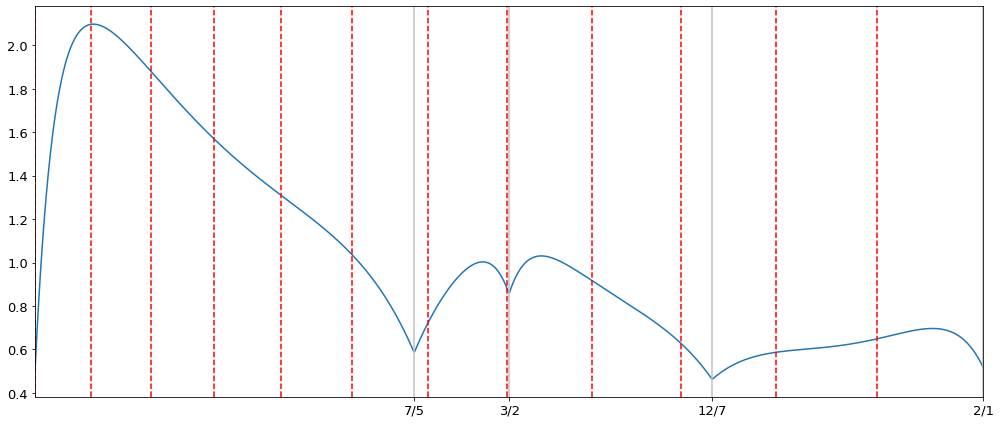

intervals [(7, 5), (3, 2), (12, 7), (2, 1)]


In [161]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 2, cons_limit = 0.1, ratios_extension = True)
biotuning.compute_diss_curve(plot = True, input_type = 'extended_peaks', euler_comp = False, denom = 100, max_ratio = 2, n_tet_grid = 12)


In [162]:
print('Dissonance curve metrics:', biotuning.scale_metrics)
print('Dissonance curve tuning:', biotuning.diss_scale)

Dissonance curve metrics: {'diss_euler': 'NaN', 'dissonance': 1.027787301252536, 'diss_harm_sim': 39.84126984126984, 'diss_n_steps': 4}
Dissonance curve tuning: [1.4, 1.5, 1.7142857142857142, 2.0]


In [163]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.diss_scale, maxdenom = 1000)
scale_frac

[Fraction(7, 5), Fraction(3, 2), Fraction(12, 7), Fraction(2, 1)]

## Harmonic entropy

Harmonic entropy takes as input a list of ratios.

If input_type = 'peaks' or 'extended_peaks', their ratios will be used.
Other input types use extended ratios : see biotuner ref.

'extended_ratios_inc'  (increments of the ratios in the form of 'r^1, r^2, r^3, ... r^n)

'extended_ratios_inc_fit' (harmonic fit between the ratios increments)

'extended_ratios_harm'


(5, 21)
(254, 6)


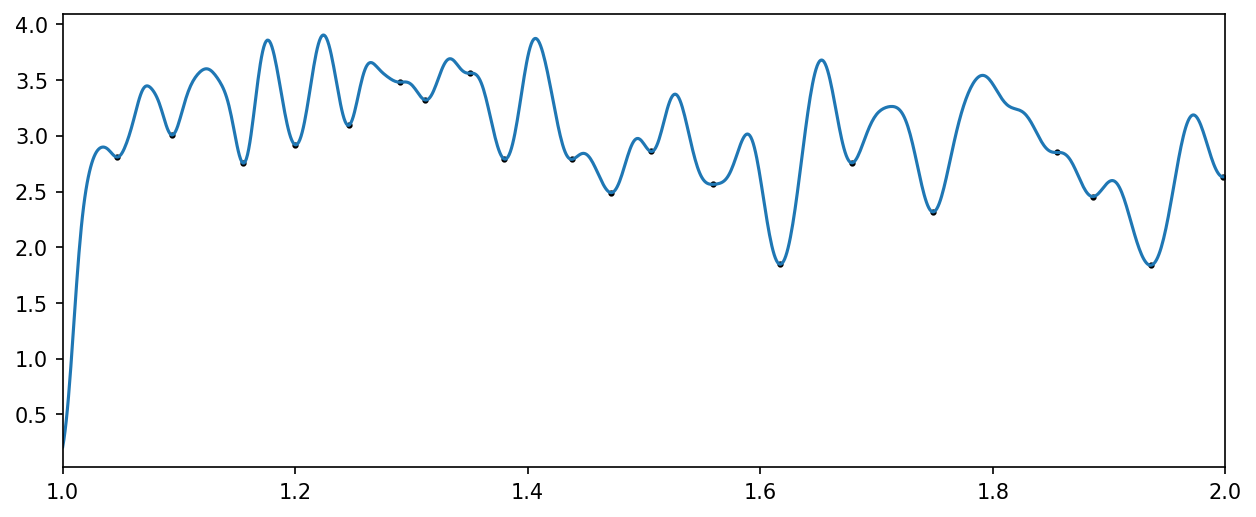

In [173]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 20, cons_limit = 0.1, ratios_extension = True)
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_inc_fit', plot_entropy = True, octave = 2, rebound = False, sub=False)

In [175]:
print('Harmonic entropy metrics:', biotuning.scale_metrics)
print('Harmonic entropy tuning:', biotuning.HE_scale)

Harmonic entropy metrics: {'diss_euler': 'NaN', 'dissonance': 1.027787301252536, 'diss_harm_sim': 39.84126984126984, 'diss_n_steps': 4, 'HE': 3.001094603626019, 'HE_n_steps': 20, 'HE_harm_sim': 2.7775024328130695}
Harmonic entropy tuning: [1.047 1.094 1.155 1.2   1.246 1.29  1.312 1.35  1.38  1.438 1.472 1.506
 1.559 1.617 1.679 1.749 1.855 1.886 1.936 1.998]


In [177]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.HE_scale, maxdenom = 100)
scale_frac

[Fraction(89, 85),
 Fraction(93, 85),
 Fraction(82, 71),
 Fraction(6, 5),
 Fraction(76, 61),
 Fraction(129, 100),
 Fraction(122, 93),
 Fraction(27, 20),
 Fraction(69, 50),
 Fraction(128, 89),
 Fraction(131, 89),
 Fraction(125, 83),
 Fraction(145, 93),
 Fraction(76, 47),
 Fraction(136, 81),
 Fraction(7, 4),
 Fraction(128, 69),
 Fraction(149, 79),
 Fraction(151, 78),
 Fraction(2, 1)]

## Exporting scale in scala format

In [187]:
create_SCL(biotuning.HE_scale, 'Harmonic_entropy_scale')
create_SCL(biotuning.diss_scale, 'Dissonance_curve_scale')
create_SCL(biotuning.peaks_ratios, 'Peaks_ratios_scale')

## Spectromorphological computation

NAN []
2


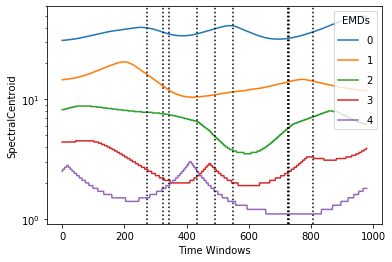

In [180]:
biotuning.compute_spectromorph(comp_chords = True, method = 'SpectralCentroid', min_notes = 5, cons_limit = 0.2, cons_chord_method = 'cons', 
                               window = 500, overlap = 1, graph = True)



In [183]:
biotuning.spectro_chords

[[1.5, 2.7, 7.8, 40.0, 16.8],
 [1.7, 2.2, 37.4, 7.7, 13.6],
 [1.8, 2.1, 36.0, 7.5, 12.5],
 [2.7, 35.0, 2.2, 6.6, 10.5],
 [1.8, 2.8, 5.2, 38.4, 10.8],
 [1.4, 2.1, 3.9, 41.4, 11.5],
 [32.2, 1.1, 2.4, 5.4, 13.8],
 [32.2, 1.1, 2.4, 5.5, 13.8],
 [1.1, 3.3, 36.0, 7.0, 14.4]]